In [22]:
import pandas as pd
import numpy as np
import nltk
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_pickle('data/out/data.pkl')
df

,name,date,revenue,runtime,languages,countries,genres,summary,phrases
0,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Black-and-white, Indie, Short Film, Silent film]",The scene is all filmed from a stationary came...,"[anvil, beer, blacksmith, camera, metal]"
1,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short Film, Silent film]",After finding out that her father is suffering...,"[Hamilton, London, York, editor, falls, financ..."
2,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short Film, Silent film]",James J. Corbett and Peter Courtney both take ...,"[boxing, hero]"
3,La Mer,1895-01-01,NaN,0.633333,[Silent film],[France],"[Black-and-white, Documentary, Indie, Short Fi...",This 38 second film has a very simple plot in ...,"[film, jetty, water]"
4,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Animation, Comedy, Indie, Short Film, Silent ...",The film consists of a series of animations on...,"[beach, boat, diving, dog, film, play, swimmin..."
...,...,...,...,...,...,...,...,...,...
42193,Kisaragi,NaT,NaN,108.000000,None,None,"[Comedy film, Mystery]",One year after the suicide of C-list model Kis...,"[death, model, suicide, talk]"
42194,Mother Fish,NaT,NaN,92.000000,[Vietnamese Language],None,[Drama],Mother Fish follows the story of a middle-aged...,"[Fish, Food, IMDb, South, Vietnamese, boat, de..."
42195,Deewana Tere Naam Ka,NaT,NaN,140.000000,[Hindi Language],None,[Drama],"Deewana Tere Naam Ka is a family drama, featur...","[Danny Denzongpa, Jagdeep, Sharat Saxena, Tere..."
42196,Hunter Prey,NaT,NaN,90.000000,None,None,[Science Fiction],A group of elite interstellar commandos crash ...,"[AI, Commander, Earth, Jericho, Lieutenant, bi..."


### Genres column exploration

In [11]:
genres = df['genres'].dropna()

In [12]:
# total number of genres
genres.explode().nunique()

363

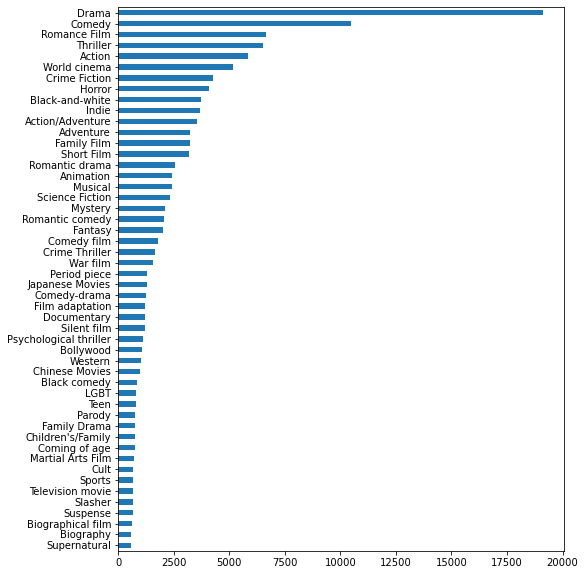

In [13]:
#distribution of top 50 common genres
dist = genres.explode().value_counts(ascending = True)
dist[-50:].plot(kind = 'barh',figsize = (8,10))

In [14]:
df = df.dropna(subset = ['genres'])

### Baseline model

In [15]:
def summary_preprocessing(plot):
    
    #remove punctuation
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punct = plot.apply(lambda x: tokenizer.tokenize(x))
    
    #remove stopwords
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    no_stopwords = no_punct.apply(lambda x: ' '.join([w for w in x if w not in stop_words]))
    
    return no_stopwords

In [16]:
def genre_to_label(genres):
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(df['genres'])
    y = multilabel_binarizer.transform(df['genres'])
    return y

In [32]:
def model(summary,label):
    #tf-idf vectorizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(df['genres'])
    label = multilabel_binarizer.transform(df['genres'])
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
    clf.fit(xtrain_tfidf,ytrain)
    y_pred = clf.predict(xval_tfidf)
    
    
    #evaluation
    f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    return f1, multilabel_binarizer.inverse_transform(y_pred)

In [24]:
df['processed_summary'] = summary_preprocessing(df['summary'])
labels = genre_to_label(df['genres'])
f1_score_summary, predict_genre_summary = model(df['processed_summary'],labels)

[nltk_data] Downloading package stopwords to
[nltk_data]     /datasets/home/66/266/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
phrases_joined = df['phrases'].apply(lambda x: ' '.join(x))
f1_score_phrase, predict_genre_phrase = model(phrases_joined,labels)

In [26]:
f1_score_summary,f1_score_phrase

(0.31565075837833645, 0.29421883959756034)

In [29]:
predict_genre_summary

[('Comedy',),
 ('Comedy',),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Science Fiction',),
 ('Crime Fiction', 'Drama'),
 (),
 ('Drama',),
 (),
 ('Drama',),
 (),
 ('Musical',),
 (),
 ('Fantasy',),
 (),
 ('Comedy', 'Family Film'),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Comedy',),
 (),
 (),
 (),
 ('Comedy',),
 ('Black-and-white', 'Drama'),
 ('Horror',),
 (),
 ('Horror', 'Science Fiction', 'Thriller'),
 ('Drama',),
 (),
 ('Drama', 'Romance Film'),
 (),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 (),
 (),
 ('Family Film',),
 (),
 ('Drama',),
 (),
 ('Drama',),
 ('Action', 'Crime Fiction', 'Drama'),
 ('Drama',),
 (),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 ('Animation', 'Family Film', 'Short Film'),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Action',),
 (),
 ('Horror',),
 (),
 ('Drama',),
 ('Drama',),
 ('Animation',),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('

In [46]:
predict_genre_phrase

[('Drama',),
 ('Comedy',),
 (),
 ('Drama',),
 ('Crime Fiction', 'Drama'),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Japanese Movies', 'Science Fiction'),
 ('Comedy',),
 (),
 ('Drama',),
 (),
 ('Drama',),
 ('Horror',),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 (),
 ('Comedy',),
 (),
 ('Drama',),
 (),
 ('Drama',),
 (),
 ('Drama',),
 ('Drama',),
 (),
 (),
 ('Crime Fiction',),
 ('Crime Fiction', 'Drama', 'Thriller'),
 ('Drama',),
 ('Comedy',),
 (),
 (),
 (),
 ('Horror', 'Science Fiction'),
 ('Thriller',),
 (),
 ('Drama', 'Romance Film'),
 ('Drama', 'Romance Film'),
 (),
 ('Comedy', 'Drama'),
 (),
 (),
 (),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Action', 'Crime Fiction'),
 ('Drama',),
 (),
 ('Comedy',),
 (),
 ('Adventure', 'Drama'),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 ('Action',),
 ('Horror',),
 (),
 ('Comedy', 'Drama', 'Romance Film'),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Dr